# What Drives the Price of a Car?

![](images/kurt.jpeg)

## Overview

In this application, we will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Our goal is to understand what factors make a car more or less expensive.  As a result of our analysis, we should provide clear recommendations to our client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem, as outlined in the sections that follow.

## Business Understanding

As previously stated, the business objective is to find the factors that affect the price of a used car. From a data problem perspective, this translates into the following question: **Which features most strongly affect the price of a used car, and which regression model provides the most accurate price predictions?**

## Data Understanding

After considering the business understanding, we want to get familiar with our data. Let's start by loading it and analyzing its structure.

### 1. General Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


### 2. Loading the Data

In [15]:
df = pd.read_csv('data/vehicles.csv')
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [3]:
df.shape

(426880, 18)

A quick overview of the data shows that it has an extensive set of features that are known to affect the price of a used car. It also has **426880** rows, which is a good size for training and testing our predictive model. As such, it can definitely be used to train and test our models, and to answer the Business question at hand.

The next step is to thoroughly analyze it before preparing it for modeling.

## Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to prepare our dataset for modeling.  Here, we want to handle any integrity issues, perform any necessary cleaning, engineer any new features, perform any transformations that we believe should happen (scaling, logarithms, normalization, etc.) before modeling with `sklearn`. 

Let's output the statistical description of our dataset.

In [4]:
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


A few things jump out right away. First, the median price is **\$75,199**. Second, the maximum price is **\$3,736,929,000**. Third, the standard deviation is **12,182,280**. Obviously, cars aren't that expensive, let alone used ones.

Those numbers suggest that there are incorrect values or outliers in the dataset. In order to confirm that hypothesis, let's show a scatter plot of the dataset. We'll set the `'yscale'` to `'log'` for better visibility.

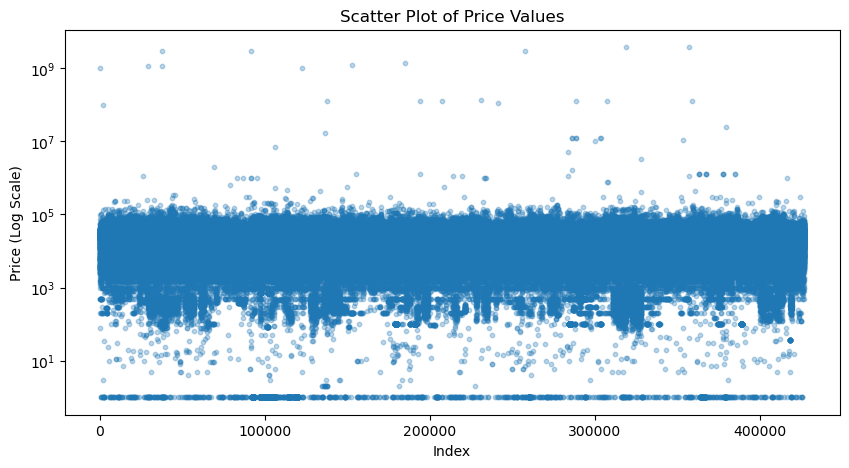

In [16]:
plt.figure(figsize=(10, 5))
plt.scatter(df.index, df['price'], alpha = 0.3, s = 10)
plt.yscale('log')
plt.title('Scatter Plot of Price Values')
plt.xlabel('Index')
plt.ylabel('Price (Log Scale)')
plt.savefig('images/price-scatter-plot.png')
plt.show()

The scatter plot confirms that there are indeed outliers in the dataset, with some values going as high as **1 billion dollars**. It also confirms that the majority of the data distribution falls between **\$1,000** and **\$100,000**. So we need to select a sample in that range to use as our new dataset. But what values should we use?

To determine a reasonable range, I did a quick Google search and found that most used cars sell between **\$1,000** for older vehicles and **\$60,000** for luxury models. Based on that research, I selected a cutoff range of **\$500** to **\$200,000**, which I found to be more realistic.

So let's create a sample within that range and use it as our new dataset.

In [17]:
# Create a sample with price range between $500 and $200,000
df = df.query('price >= 500 & price <= 200000')
df.describe()

,id,price,year,odometer
count,3.846620e+05,384662.000000,383489.000000,3.825400e+05
mean,7.311466e+09,19312.899587,2010.972030,9.851708e+04
std,4.477570e+06,14990.206166,9.601722,1.920005e+05
min,7.207408e+09,500.000000,1900.000000,0.000000e+00
25%,7.308083e+09,7800.000000,2008.000000,3.818425e+04
50%,7.312586e+09,15900.000000,2013.000000,8.768400e+04
75%,7.315244e+09,27990.000000,2017.000000,1.360000e+05
max,7.317101e+09,200000.000000,2022.000000,1.000000e+07


Now we have a median price of **\$19,312** and a standard deviation of **14,990**, which are more realistic.

Next, let's look for missing values.

In [6]:
# Output missing rows
missing_rows = df.isnull().sum()
missing_rows

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

The data has a large number of missing values, especially for features such as `manufacturer`, `condition`, `cylinders`, `size`, and `paint_color`. Because those features are usual predictors of the price of a used car, we'll keep them instead of dropping them. We'll handle missing values durng the modeling phase.

Let's now analyze the structure of the data and clean it if needed.

In [7]:
# Analyze the structure of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

First, we can see that the `'cylinders'` column is of type `'object'` rather than `'int64'`. Let's review its unique values, clean those values if needed, and convert the column to its appopriate type.

In [18]:
# Output the unitque values for the `cylinders` column
df['cylinders'].unique()

array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
       'other', '3 cylinders', '10 cylinders', '12 cylinders'],
      dtype=object)

As can be seen, the values contain the `'cylinders'` string. Let's strip those strings and convert the column.

In [19]:
# Convert the `cylinder` column to `int64` type
df['cylinders'] = df['cylinders'].str.extract(r'(\d+)').astype(float) # I'm temporarily using 'float' to preserve NaN values
df['cylinders'] = df['cylinders'].astype('Int64')
df['cylinders'].unique()

<IntegerArray>
[<NA>, 8, 6, 4, 5, 3, 10, 12]
Length: 8, dtype: Int64

Now the `'cylinders'` column is of the appropriate `'int64'` type; its values have been correctly converted; and all `'N/A'` values have been preserved.

Next, we can see that the `'year'` and `'odometer'` columns are of type `'float64'`. They should be of type `'int64'` because their values are always whole numbers, not decimals. Let's fix that.

In [20]:
# Convert the `year` and `odometer` columns to 'int64` type
df['year'] = df['year'].astype('Int64')
df['odometer'] = df['odometer'].astype('Int64')
df.dtypes

id               int64
region          object
price            int64
year             Int64
manufacturer    object
model           object
condition       object
cylinders        Int64
fuel            object
odometer         Int64
title_status    object
transmission    object
VIN             object
drive           object
size            object
type            object
paint_color     object
state           object
dtype: object

The `'year'` and `'odometer'` are now of the appropriate type.

Finally, it is safe to say that the `'id'`, `'region'`, `'VIN'`, and `'state'` features do not usually affect the price of a car; so let's drop them completely.

In [21]:
# Drop the 'id', `region`, `VIN`, and `state` columns
car_df = df.drop(columns = ['id', 'region', 'VIN', 'state'])
car_df.dtypes

price            int64
year             Int64
manufacturer    object
model           object
condition       object
cylinders        Int64
fuel            object
odometer         Int64
title_status    object
transmission    object
drive           object
size            object
type            object
paint_color     object
dtype: object

Our data is now clean and ready for modeling.

## Modeling

With our final dataset in hand, it is now time to build our models. 

Our modeling process will follow these steps:
- First, we'll use the **price** as the target. All other columns will be treated as features
- Second, we'll split our dataset as follows: **70%** for training and **30%** for testing
- Third, as part of our preprocessing logic, we'll apply a transformation to our columns. This will help us handle numeric features (i.e. `year`, `cylinders`) and categorical features (i.e. `condition`, `transmission`) appropriately
- Fourth, we'll create two models, each with a `PolynomialFeatures(degree = 3)` step:
    - a simple **LinearRegression** model
    - a **Ridge** with **GridSearchCV** model
- Fifth, we'll train our models, make predictions, and select the one with the lowest **MSE**.
- Finally, we'll inspect the features of our selected model to answer our business question.

**Note:**
I'll be using `"degree = 3"`for the `PolynomialFeatures` step of each pipeline for the following reasons: first, it creates cubic powers, which results into a manageable feature space. Second, it prevents me from creating different candidate values and looping over them, just to select the most appropriate one. Finally, it is the value often used in most course assignments and Colab activities.

### 1. Creating the Train/Test Split

First, let's define our features and target, and then perform our data split.

In [22]:
# Create the feature datadrame and target column
X = car_df.drop(columns = ['price'])
y = car_df['price']

# Define our numeric and categorical columns
numeric_columns = X.select_dtypes(include = [np.number]).columns.tolist()
categorical_columns = X.select_dtypes(exclude = [np.number]).columns.tolist()

print(f'Numeric columns: {numeric_columns}')
print(f'Categorical columns: {categorical_columns}')

# Create our train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

print(f'\nTrain: {X_train.shape} - Test: {X_test.shape}')

Numeric columns: ['year', 'cylinders', 'odometer']
Categorical columns: ['manufacturer', 'model', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color']

Train: (269263, 13) - Test: (115399, 13)


### 2. Preprocessimg the Columns

Next, we'll preprocess our numeric and categorical columns. We do so because different data types require different transformations. Numeric columns will need imputation and scaling, while categorical columns will need imputation and "One-Hot Encoding". We perform those transformations with a `ColumnTransformer` transformer. 

In [23]:
# Preprocess the columns with `ColumnTransformer`
numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler()),
    ('pfeatures', PolynomialFeatures(degree = 3, include_bias = False))
])

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown = 'ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('numeric', numeric_transformer, numeric_columns),
        ('categorical', categorical_transformer, categorical_columns)
    ],
    remainder = 'drop'
)

preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('pfeatures',
                                                  PolynomialFeatures(degree=3,
                                                                     include_bias=False))]),
                                 ['year', 'cylinders', 'odometer']),
                                ('categorical',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['manufacturer', 'model', 'condition', 'fuel',
                                  'title_status', 'transmission', 'drive',
                                  'size', 'type', 'paint_color'])])

Now that our column preprocessor has been defined, we can create our models, starting with the baseline **LinearRegression** model.

### 3. Creating and Training the `LinearRegression` Model

In [24]:
# Creating and training the basic `LinearRegression` model, and using it
# to make price predictions
linreg_pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
linreg_pipe.fit(X_train, y_train)

linreg_train_preds = linreg_pipe.predict(X_train)
linreg_test_preds = linreg_pipe.predict(X_test)

linreg_mse_train = mean_squared_error(y_train, linreg_train_preds)
linreg_mse_test = mean_squared_error(y_test, linreg_test_preds)

print(f'LinearRegression - Train MSE: {linreg_mse_train:.3f} - Test MSE: {linreg_mse_test:.3f} - Test RMSE: {np.sqrt(linreg_mse_test):.3f}')


LinearRegression - Train MSE: 61239155.989 - Test MSE: 62284654.219 - Test RMSE: 7892.063


The test MSE for the LinearRegression model is **62284654**. Its square root value (RMSE) means that its predictions are off by about **\$7,892**.

Let's create and train our second model.

### 4. Creating and Training the `Ridge + GridSearchCV`Model

We create and train a `Ridge` model with `GridSearchCV` to apply regularization. Since our feature space contains polynomial terms and many one-hot-encoded categorical columns, `Ridge` will help stabilize the model by reducing overfitting.

An important parameter of a `Ridge` model is the `alpha` hyperparameter. It controls how strongly `Ridge` regularizes the model. For our use case, we'll create a range of alpha values so that the model can explore regularization strengths across several orders of magnitude. We then provide those candidate values to `GridSearchCV`, which will test them and select the most effective one for our dataset.


In [25]:
# Create a range of candidate values for `alpha`
alpha_values = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

# Create a Ridge model, train it, and use it to make predictions
ridge_pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

ridge_param_grid = {
    'ridge__alpha': alpha_values
}

ridge_cv = GridSearchCV(
    estimator = ridge_pipe,
    param_grid = ridge_param_grid,
    cv = 5,
    scoring = 'neg_mean_squared_error'
)
ridge_cv.fit(X_train, y_train)

best_ridge_estimator = ridge_cv.best_estimator_
best_ridge_alpha = ridge_cv.best_params_['ridge__alpha']

print(f'Ridge - Best alpha value: {best_ridge_alpha}')

ridge_train_preds = best_ridge_estimator.predict(X_train)
ridge_test_preds = best_ridge_estimator.predict(X_test)

ridge_mse_train = mean_squared_error(y_train, ridge_train_preds)
ridge_mse_test = mean_squared_error(y_test, ridge_test_preds)

print(f'Ridge - Train MSE: {ridge_mse_train:.3f} - Test MSE: {ridge_mse_test:.3f} - Test RMSE: {np.sqrt(ridge_mse_test):.3f}')

Ridge - Best alpha value: 0.001
Ridge - Train MSE: 42870246.026 - Test MSE: 50598928.582 - Test RMSE: 7113.292


Our `Ridge` model has a test MSE of **50598928**, which is lower than that of the LinearRegression model. And its test RMSE means that its predictions are off by **\$7,113**.

**We'll choose the `Ridge` model as our best model because it has a lower test MSE.**

Let's now evaluate its performance.

### Evaluation

With our modeling accomplished, we can now inspect our model and extract its top features, which will help answer our business question.

In [26]:
# Extract the feature names from the Ridge preprocessor
feature_names = best_ridge_estimator.named_steps['preprocessor'].get_feature_names_out()

# Extract the coefficients from the Ridge model
coefficients = best_ridge_estimator.named_steps['ridge'].coef_

# Create a dataframe of the features and coefficients
important_features = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients
})
important_features = important_features.sort_values(
    by = 'coefficient', 
    key = (lambda col: col.abs()), 
    ascending = False
)

important_features.head(10)

,feature,coefficient
4406,categorical__model_Lamborghini Huracan,151541.871316
4940,categorical__model_ROLLS ROYCE PHANTOM,121999.135936
16119,categorical__model_nsx,112748.042196
4590,categorical__model_Mclaren 570GT W/ Upgrades,110337.267008
4239,categorical__model_Intertational,99388.665091
12938,categorical__model_g-class,98414.647032
3973,categorical__model_HTLINER Cascadia,88869.591966
3238,categorical__model_Bentley Bentayga Activity E...,88123.216079
4839,categorical__model_Peterbilt 379 EXHD,88064.845164
6257,categorical__model_amg gt,87181.093671


Our dataframe contains the expanded features as well as their respective coefficient. However, this data still cannot answer our question. We need to extract the actual feature names (i.e. `'model'`) from the expanded features (i.e. `'categorical__model_Lamborghini Huracan'`).

First, we'll use a sample of the dataset that contains the top 5 features. Next, we'll extract the parent feature names and add them to a `'feature_name'` column in our dataframe. 

**Note:**
After testing different values, I found that using the top 5000 rows returns a sample that contains 5 features.

In [27]:

def extract_feature_name(feature_name):
    '''
      Converts feature names such as "categorical__model_Lamborghini Huracan" 
      or "numeric_odometer" into their parent feature names: "model" or "odometer"
    '''
    parts = feature_name.split("__")
    feature_type = parts[1]
    
    return feature_type.split('_')[0]

# After testing different values, I found that using the top 5000 rows returns
# a sample that contains 5 features
top_features = important_features.head(5000).copy()
top_features['feature_name'] = top_features['feature'].apply(extract_feature_name)
top_feature_counts = top_features['feature_name'].value_counts()
top_feature_counts

feature_name
model           4978
manufacturer      19
year               1
fuel               1
odometer           1
Name: count, dtype: int64

**As can be seen, the top predictors of a used car price are the `model`, `manufacturer`, `year`, `fuel`, and `odometer`**.

Let's plot our dataframe to visualize their relative importance.

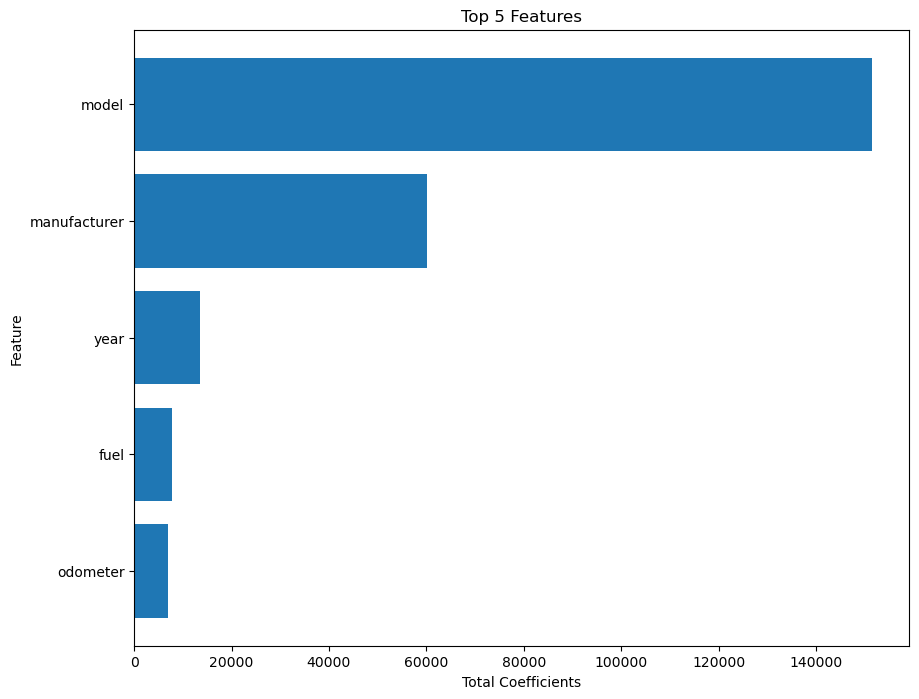

In [28]:
# Plot the top 5 features
plt.figure(figsize = (10, 8))
plt.barh(top_features['feature_name'], top_features['coefficient'].abs())
plt.gca().invert_yaxis()
plt.title('Top 5 Features')
plt.xlabel('Total Coefficients')
plt.ylabel('Feature')
plt.savefig('images/top-5-features.png')
plt.show()

## Deployment

Now that we've settled on our model and findings, it is time to deliver the information to our audience, a group of used car dealers interested in fine-tuning their inventory.

### 1. Objective

The objective of this project was to identify which vehicle features have the strongest influence on used-car prices. This information will enable you to fine-tune your inventory, set competitive prices, and improve purchasing decisions.

### 2. Findings

After analyzing more than 400,000 used-car listings and building a reliable price-prediction model, we've identified the five features that have the strongest impact on prices.

The first two are by far the most influential. The remaining ones are secondary but still meaningful.

1. **Model**: This is the single most important factor. Buyers typically search for a specific model first, and only then do they evaluate additional details.
2. **Manufacturer:** This is the second most important feature. Choosing a model and then a manufacturer is a logical selection process that people usually follow.
3. **Year**: Newer vehicles still command higher prices; so make sure to update your inventory regularly.
4. **Fuel Type:** People are very sensitive to fuel type. Gas, hybrid, or electric car definitely have different resale values. This feature is not as important as the model, but it becomes useful if the chosen model offers different fuel types.
5. **Odometer:** Mileage still remains a key factor since it determines the remaining lifespan of a car. Lower-mileage vehicles consistently yield higher resale value. So make sure to update your inventory accordingly.

### 3. Conclusion

In summary, our analysis reveals clear and actionable insights into the features that most strongly influence used-car prices. I'd recommend that you focus on high-value models, reputable manufacturers, newer model years, desirable fuel types, and lower-mileage vehicles. I'd also recommend that you update your inventory accordingly.

Our model provided a solid foundation for data-driven price predictions; however, it is still not perfect. I look forward to returning in the near future with an even more optimized version — one that will leverage additional features and improved algorithms to make even more accurate predictions.